# Ford Go Bike Data for February 2019
## by Doug Plager, 2021_08_28

## Investigation Overview
  Increasing the typical bike ride time is likely a goal of a bike-sharing system. Therefore, after preliminary data analyses, I was interested in identifying factors that contribute to longer, common-duration bike ride times. Specifically, I was curious about how (a) the start time, (b) the distance between start and end station, (c) bike id (with respect to the introduction of ebikes), (d) user type, (e) user age, and (f) user gender related to bike ride duration.<br>
  
## Dataset Overview
  This dataset ("201902-fordgobike-tripdata.csv" file provided by Udacity) includes information about approximately 183,000 individual bike rides within the Ford Go Bike bike-sharing system in the greater San Francisco Bay area and San Jose during the month of February 2019. Additional information about the Ford Go Bike bike-sharing system can be found **[here](https://mtc.ca.gov/node/121741)**.<br>
  Data rows containing inaccurate `member_birth_year` values, at least one NaN, high values for `duration_sec` (>9600 sec), or high values for `lin_distance` between the starting and ending station were dropped during initial data analyses to obtain a "cleaned" working dataset of 174,503 bike ride entries.

In [1]:
# Import all packages and set plots to be embedded inline.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# Suppress warnings from final output.
import warnings
warnings.simplefilter("ignore")

In [2]:
# Load the initial Ford Go Bike, San Francisco Bay area and San Jose, February 2019, dataset.
gobike_df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# DATA WRANGLING:  Convert 'start_time' and 'end_time' columns to "datetime" datatype.
gobike_df.start_time = pd.to_datetime(gobike_df.start_time)
gobike_df.end_time = pd.to_datetime(gobike_df.end_time)

In [4]:
# DATA WRANGLING:  Drop data rows containing inaccurate `member_birth_year` values, at least one NaN, 
# high values for `duration_sec` (>9600 sec), or high values for `lin_distance` between the starting and ending station
# to obtain a "cleaned" working dataset of 174,503 bike ride entries.

# Drop the 72 'inaccur_birth_year' rows  and  ASSIGN TO NEW 'gobike_clean' DATAFRAME.
inaccur_birth_yr = gobike_df.query('member_birth_year < 1919')
gobike_clean = gobike_df.drop(inaccur_birth_yr.index)

# Drop all 8460 rows that contain at least one NaN.
gobike_clean.dropna(axis=0, inplace=True)

# Filter out the relatively few (376) "very long" duration bike rides and just consider the 
# distribution of bike rides with 'duration_sec' <= 9600 sec (160 min).
gobike_clean = gobike_clean.query('duration_sec <= 9600')

# Drop the index 112038 row associated with an extremely long ~69.5 km 'lin_distance' (see next Code Cell) 
# between start and end station.
gobike_clean.drop(112038, axis=0, inplace=True)

In [5]:
# DATA WRANGLING:  Add columns for log10 transformation of 'duration_sec' ('log10_duration'), for the linear distance
# between start and end station ('lin_distance')


# Add a column of log10-transformed 'duration_sec' data to the 'gobike_clean' DataFrame For upcoming bivariate explorations.
gobike_clean['log10_duration'] = np.log10(gobike_clean['duration_sec'])


# Add a column of linear distances between the start station and end station (in km) to the 'gobike_clean' DataFrame:
    # Define a function to calculate the linear distance between a start station and a end station using the Haversine formula.
    # NOTE: Output in kilometers.

    # REFERENCES:
    # 1. https://stackoverflow.com/questions/34502254/vectorizing-haversine-distance-calculation-in-python
    # 2. https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python

'''
Purpose: Calculate the linear distance in kilometers between two points of latitude and longitude using the Haversine formula.

lat1:  Accepts the latitude value for the first of two points (e.g., 'start_station_latitude' value).
lon1:  Accepts the longitude value for the first of two points (e.g., 'start_station_longitude' value).
lat2:  Accepts the latitude value for the second of two points (e.g., 'end_station_latitude' value).
lon2:  Accepts the longitude value for the second of two points (e.g., 'end_station_longitude' value).

Returns: A single float value for the linear distance between the two points with units of kilometers.
'''

def haversine(lat1, lon1, lat2, lon2):
    earth_rad = 6371    # Kilometer units.
    
    lat_diff = np.radians(lat2 - lat1)
    lon_diff = np.radians(lon2 - lon1)
    
    a = (np.sin(lat_diff / 2.) * np.sin(lat_diff / 2.) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(lon_diff / 2.) * np.sin(lon_diff / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = earth_rad * c
    return d    # in kilometers.

    # Calculate the linear distance between the start station and end station for each bike ride.
    # REFERENCE:  https://www.codeforests.com/2020/07/18/pass-multiple-columns-to-lambda/
lin_distance_2 = gobike_clean.apply(lambda x: haversine(x['start_station_latitude'], x['start_station_longitude'], 
                                                     x['end_station_latitude'], x['end_station_longitude']), axis=1)
    # Add the 'lin_distance' column to 'gobike_clean' DataFrame.
gobike_clean['lin_distance'] = lin_distance_2


# Generate a 'rider_age' column from the 'member_birth_year' column and add it to 'gobike_clean' DataFrame.
current_yr = 2019
gobike_clean['rider_age'] = current_yr - gobike_df.member_birth_year


# Add the starting hour and starting day of the week categoric (eventhough numeric) variables of interest; 
# REM: Mon = 0 to Sun = 6 for day of the week data.
gobike_clean['start_time_hr'] = gobike_clean.start_time.dt.hour
gobike_clean['start_time_dotw'] = gobike_clean.start_time.dt.weekday

In [6]:
# Check my current working 'gobike_clean' DataFrame.
gobike_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174503 entries, 4 to 183411
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174503 non-null  int64         
 1   start_time               174503 non-null  datetime64[ns]
 2   end_time                 174503 non-null  datetime64[ns]
 3   start_station_id         174503 non-null  float64       
 4   start_station_name       174503 non-null  object        
 5   start_station_latitude   174503 non-null  float64       
 6   start_station_longitude  174503 non-null  float64       
 7   end_station_id           174503 non-null  float64       
 8   end_station_name         174503 non-null  object        
 9   end_station_latitude     174503 non-null  float64       
 10  end_station_longitude    174503 non-null  float64       
 11  bike_id                  174503 non-null  int64         
 12  user_type       

In [7]:
# Check the start of my current working 'gobike_clean' DataFrame.
gobike_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,log10_duration,lin_distance,rider_age,start_time_hr,start_time_dotw
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,...,4898,Subscriber,1974.0,Male,Yes,3.200029,2.409301,45.0,23,3
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,...,5200,Subscriber,1959.0,Male,No,3.253580,3.332203,60.0,23,3
6,1147,2019-02-28 23:55:35.104,2019-03-01 00:14:42.588,300.0,Palm St at Willow St,37.317298,-121.884995,312.0,San Jose Diridon Station,37.329732,...,3803,Subscriber,1983.0,Female,No,3.059563,2.028551,36.0,23,3
7,1615,2019-02-28 23:41:06.766,2019-03-01 00:08:02.756,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,6329,Subscriber,1989.0,Male,No,3.208173,4.532568,30.0,23,3
8,1570,2019-02-28 23:41:48.790,2019-03-01 00:07:59.715,10.0,Washington St at Kearny St,37.795393,-122.404770,127.0,Valencia St at 21st St,37.756708,...,6548,Subscriber,1988.0,Other,No,3.195900,4.532568,31.0,23,3


In [8]:
# Check the end of my current working 'gobike_clean' DataFrame.
gobike_clean.tail()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,log10_duration,lin_distance,rider_age,start_time_hr,start_time_dotw
183407,480,2019-02-01 00:04:49.724,2019-02-01 00:12:50.034,27.0,Beale St at Harrison St,37.788059,-122.391865,324.0,Union Square (Powell St at Post St),37.788300,...,4832,Subscriber,1996.0,Male,No,2.681241,1.464766,23.0,0,4
183408,313,2019-02-01 00:05:34.744,2019-02-01 00:10:48.502,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,66.0,3rd St at Townsend St,37.778742,...,4960,Subscriber,1984.0,Male,No,2.495544,1.402716,35.0,0,4
183409,141,2019-02-01 00:06:05.549,2019-02-01 00:08:27.220,278.0,The Alameda at Bush St,37.331932,-121.904888,277.0,Morrison Ave at Julian St,37.333658,...,3824,Subscriber,1990.0,Male,Yes,2.149219,0.379066,29.0,0,4
183410,139,2019-02-01 00:05:34.360,2019-02-01 00:07:54.287,220.0,San Pablo Ave at MLK Jr Way,37.811351,-122.273422,216.0,San Pablo Ave at 27th St,37.817827,...,5095,Subscriber,1988.0,Male,No,2.143015,0.747282,31.0,0,4
183411,271,2019-02-01 00:00:20.636,2019-02-01 00:04:52.058,24.0,Spear St at Folsom St,37.789677,-122.390428,37.0,2nd St at Folsom St,37.785000,...,1057,Subscriber,1989.0,Male,No,2.432969,0.710395,30.0,0,4


## Distribution of Bike Ride Durations (Figure 1)
Because bike ride duration is the main "outcome" variable of interest, initial univariate analyses of `duration_sec` data and its log10-transformed data, `log10_duration`, were performed.  After having filtered out the 376 bike rides >9600 sec in duration, the right-skewed `duration_sec` data (Figure 1, left) contained no extreme outliers and the log10-transformed data showed a unimodal and fairly symmetric distribution (Figure 1, right). Thus, duration data was further analyzed as a whole given that there was no obvious delineation between a low-duration group(s) and a high-duration group(s).<br><br>
('Down' arrow to view Sub-Slide)

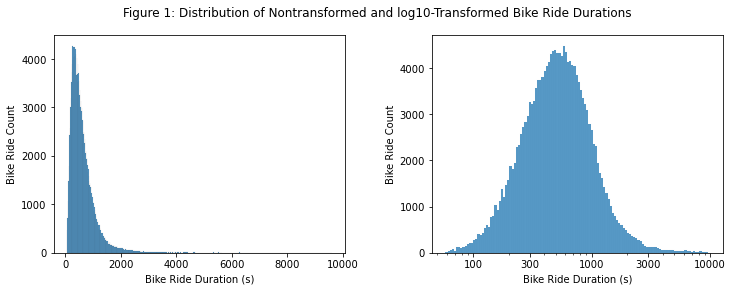

In [9]:
# Histograms of 'duration_sec' values <= 9600 sec on a linear scale and on a log10 scale for all 'gobike_clean' bike rides.

fig = plt.figure(figsize=[12, 4])
plt.suptitle('Figure 1: Distribution of Nontransformed and log10-Transformed Bike Ride Durations')

# Left subplot.
plt.subplot(1, 2, 1)

y_ticks1 = [0, 1000, 2000, 3000, 4000]

sb.histplot(gobike_clean['duration_sec'], kde=False)
plt.xlabel('Bike Ride Duration (s)')
plt.yticks(y_ticks1, y_ticks1)
plt.ylabel('Bike Ride Count')

# Right subplot.
plt.subplot(1, 2, 2)    # REM: Generate an initial  sb.histplot(gobike_clean['log10_duration'])  to obtain a good estimate of
                        #      bin width  and  log10-axis range.
log10_bin_w = 0.018
log10_x_bins = np.arange((gobike_clean.log10_duration.min() - log10_bin_w), 
                         (gobike_clean.log10_duration.max() + log10_bin_w), log10_bin_w)
x_bins = 10**log10_x_bins
x_ticks2 = [100, 300, 1000, 3000, 10000]

sb.histplot(gobike_clean['duration_sec'], bins=x_bins, kde=False)
plt.xscale('log')
plt.xticks(x_ticks2, x_ticks2)    # REM: (locations, labels)
plt.xlabel('Bike Ride Duration (s)')
plt.ylabel('Bike Ride Count');

plt.subplots_adjust(wspace=0.3);

## Distributions of Bike Ride Starting Hour and Starting Day of the Week (Figure 2)
Interestingly, univariate distributions of bike ride `start_time_hr` and `start_time_dotw` (day of the week) values clearly showed bike ride frequencies that peaked at traditional workday start (hour 8; 8 am) and end (hour 17; 5 pm) hours (Figure 2, left) and that were around two times more frequent on each traditional work day (Monday through Friday) compared to each weekend day (Saturday and Sunday) (Figure 2, right).

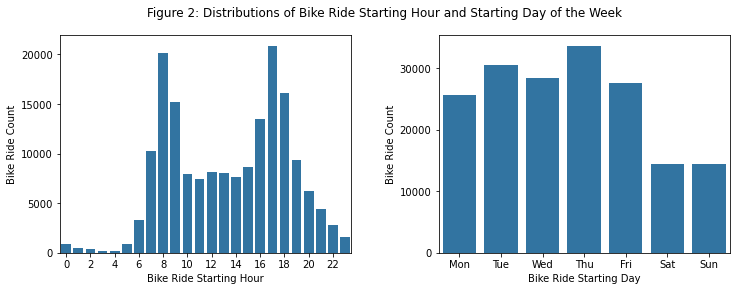

In [10]:
# Bike ride frequency across each hour of the day and each day of the week for all 'gobike_clean' bike rides.

color_0 = sb.color_palette()[0]    # Flat blue-grey color.

fig = plt.figure(figsize=[12, 4])
plt.suptitle('Figure 2: Distributions of Bike Ride Starting Hour and Starting Day of the Week')

# Left subplot.
plt.subplot(1, 2, 1)

x_ticks1 = np.arange(0, 23, 2)
y_ticks1 = np.arange(0, 20001, 5000)

sb.countplot(x=gobike_clean.start_time_hr, color=color_0)
plt.xticks(x_ticks1, x_ticks1)
plt.xlabel('Bike Ride Starting Hour')
plt.yticks(y_ticks1, y_ticks1)
plt.ylabel('Bike Ride Count')

# Right subplot.
plt.subplot(1, 2, 2)

x_tick_locs2 = [0, 1, 2, 3, 4, 5, 6]
x_tick_labels2 = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y_ticks2 = np.arange(0, 30001, 10000)

sb.countplot(x=gobike_clean.start_time_dotw, color=color_0);    # REM:  Monday = 0, Sunday = 6
plt.xticks(x_tick_locs2, x_tick_labels2)
plt.xlabel('Bike Ride Starting Day')
plt.yticks(y_ticks2, y_ticks2)
plt.ylabel('Bike Ride Count');

plt.subplots_adjust(wspace=0.3);    # To provide a bit more space between the two subplots.

## Distribution of Bike Rider Ages (Figure 3)
The univariate distribution of `rider_age` (Figure 3) also showed an elevated number of bike rides by "working age" individuals who probably are more likely to bike to work, i.e., approximately 25-36 years of age.

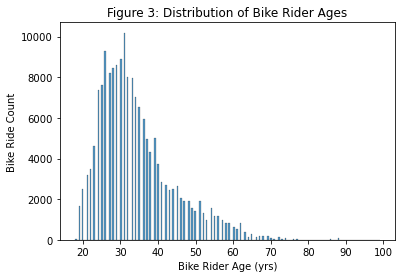

In [11]:
# Histogram of discrete numeric rider age values for all 'gobike_clean' bike rides.
sb.histplot(gobike_clean.rider_age)
plt.title('Figure 3: Distribution of Bike Rider Ages')
plt.xlabel('Bike Rider Age (yrs)')
plt.ylabel('Bike Ride Count');

## Distribution of Bike Ride Start-to-End Station Distances (Figure 4)
This final univariate distribution of `lin_distance` (linear distance between start and end station) showed a "zero linear distance" subpopulation of bike rides (i.e., "round trip" bike rides starting and ending at the same station) along with a right-skewed "nonzero linear distance" subpopulation of bike rides (Figure 4), the latter of which after log10 transformation displayed a relatively unimodal and symmetric distribution (data not shown). Also, only a small number of bike rides involve a start-to-end station distance between 8 and 16 km.

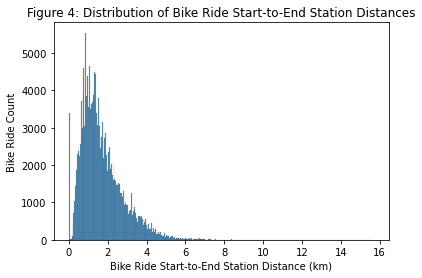

In [12]:
# Histogram of linear distances between the start and end station for all 'gobike_clean' bike rides.
sb.histplot(data=gobike_clean, x='lin_distance')
plt.title('Figure 4: Distribution of Bike Ride Start-to-End Station Distances')
plt.xlabel('Bike Ride Start-to-End Station Distance (km)')
plt.ylabel('Bike Ride Count');

## Conclusions from Univariate Analyses:
> The preceding univariate analyses suggest the presence among the Ford Go Bike system riders of:<br><br>
 (a) a subpopulation of "work commuter" bikers (Figure 2 and 3), and<br><br>
 (b) some other subpopulation of zero-distance "recreational, round trip" bikers (Figure 4).

## Average Duration vs. Starting Hour and vs. Starting Day of the Week (Figure 5)
An initial bivariate scatterplot of `duration_sec` vs. `start_time_hr` suggested an increased number of longer duration bike rides during the midday hours (roughly 10 am to 5 pm) (data not shown). To avoid the overplotting associated with the initial scatterplot, the average bike ride duration was plotted across the starting hours of the bike rides (Figure 5, left). The variability in early morning hour (hour 0 to 5) bike ride durations makes it difficult to confidently state that a peak in duration occurs at hour 2 (2 am); however, there is a clear increase in bike ride duration during the "midday" hours of hour 11 (11 am) through hour 15 (3 pm). Similarly, the average bike ride duration was plotted across the starting day of the week for the bike rides (Figure 5, right), and this showed an increased average duration on the weekend days, Saturday and Sunday. Overall, these results are potentially unexpected given the apparently prominent work commuter subpopulation, which might not be expected to take longer bike rides during the midday hours or on the weekend days.

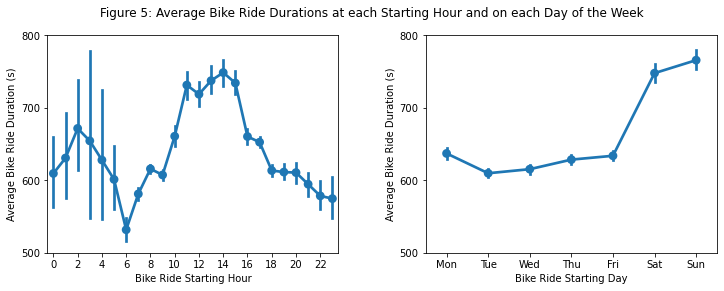

In [13]:
# Average bike ride duration across each hour of the day and each day of the week for all 'gobike_clean' bike rides.

fig = plt.figure(figsize=[12, 4])
plt.suptitle('Figure 5: Average Bike Ride Durations at each Starting Hour and on each Day of the Week')

y_ticks3 = np.arange(500, 801, 100)

# Left subplot: AVERAGE (nontransformed) duration times vs. start_time_hr.
plt.subplot(1, 2, 1)
sb.pointplot(data=gobike_clean, x='start_time_hr', y='duration_sec')
plt.xticks(x_ticks1, x_ticks1)
plt.xlabel('Bike Ride Starting Hour')
plt.yticks(y_ticks3, y_ticks3)
plt.ylabel('Average Bike Ride Duration (s)')

# Right subplot: AVERAGE (nontransformed) duration times vs. start_time_dotw (Mon=0 through Sun=6).
plt.subplot(1, 2, 2)
sb.pointplot(data=gobike_clean, x='start_time_dotw', y='duration_sec')
plt.xticks(x_tick_locs2, x_tick_labels2)
plt.xlabel('Bike Ride Starting Day')
plt.yticks(y_ticks3, y_ticks3)
plt.ylabel('Average Bike Ride Duration (s)');

plt.subplots_adjust(wspace=0.3); 

## Bike Ride Duration for both User Types (Figure 6)
Interestingly, the most apparent difference in bike ride duration involved the "Subscriber" compared to the "Customer" user type, based on both the median (Figure 6, left; plotted using `log10_duration` to better distribute y-axis values) and the average (Figure 6, right) bike ride duration.

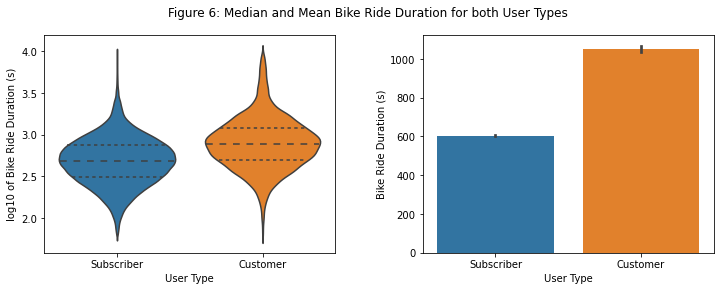

In [14]:
# Bike ride Median duration or Average duration for each user_type, i.e., Subscriber or Customer.

plt.figure(figsize=[12, 4])
plt.suptitle('Figure 6: Median and Mean Bike Ride Duration for both User Types')


# Left subplot:  Violinplot of log10 of bike ride duration quartiles, including medians, for each User Type.
plt.subplot(1, 2, 1)
sb.violinplot(data=gobike_clean, x='user_type', y='log10_duration', inner='quartile');
plt.xlabel('User Type')
plt.ylabel('log10 of Bike Ride Duration (s)')
             
# LESS VISUALLY APPEALING "log scale" ALTERNATIVE:
# sb.violinplot(data=gobike_clean, x='user_type', y='duration_sec', inner='quartile')
# plt.ylabel('Bike Ride Duration (s)')
# plt.yscale('log');

             
# Right subplot:  Barplot of bike ride duration averages for each User Type.
plt.subplot(1, 2, 2)
sb.barplot(data=gobike_clean, x='user_type', y='duration_sec')
plt.xlabel('User Type')
plt.ylabel('Bike Ride Duration (s)');

plt.subplots_adjust(wspace=0.3);
             
# NOTE: Apparently, a bootstrapping/resampling confidence interval of the sample mean (ci=  parameter default) as the 
#       "error" for sb.barplot(); thus, presumably, a std dev of the means of multiple resamplings divided by the 
#       sqrt of the samples' size (n) for a "standard error of the mean"-type error. This compared to  ci='sd' (std. dev.) 
#       to reflect, in this case, the spread of the individual 'duration_sec' values.

## Distributions of Bike Ride Starting Hour and Starting Day of the Week for both User Types (Figure 7)
Because bike ride duration was increased during the midday, on the weekend days, and for Customers compared to Subscribers (Figures 5 and 6), the absolute counts of bike rides across start hour and start day-of-the-week for Subscribers only and Customers only were considered (Figure 7). These user-specific frequency plots were consistent with the approximately eight times greater number of bike rides for Subscribers compared to Customers (data not shown). Also, Figure 7 showed that Customers take a proportionally greater number of their bike rides during the midday hours and on the weekend days compared to that of Subscribers, who bike more around peak workday start (hour 8; 8 am) and end (hour 17; 5 pm) hours and on traditional workweek days.

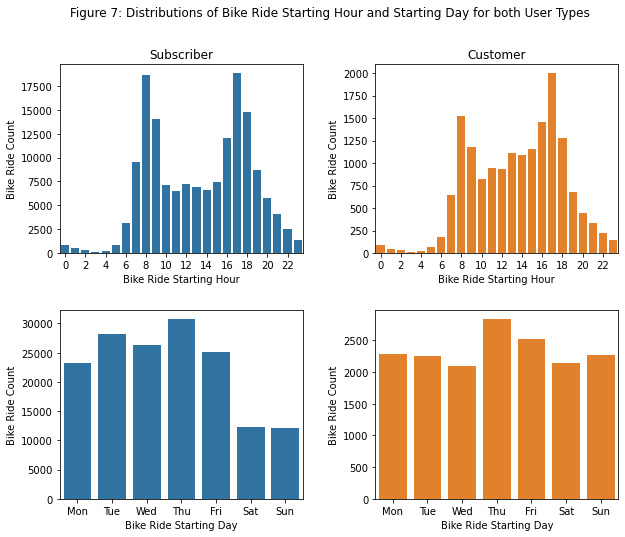

In [15]:
# Absolute bike ride counts for "Subscriber" and "Customer" user_type at each starting hour 
# and on each starting day of the week.

color_1 = sb.color_palette()[1]    # Dark orange.

user_info = [['Subscriber', color_0],
               ['Customer', color_1]]

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10,8])
plt.suptitle('Figure 7: Distributions of Bike Ride Starting Hour and Starting Day for both User Types')

i = 0
for cat, color in user_info:
    plot_data = gobike_clean.query('user_type == @cat')
    sb.countplot(x=plot_data.start_time_hr, ax=ax[0,i], color=color)
    ax[0,i].set_xticks(x_ticks1)
    ax[0,i].set_xticklabels(x_ticks1)
    ax[0,i].set_xlabel('Bike Ride Starting Hour')
    ax[0,i].set_ylabel('Bike Ride Count')
    ax[0,i].set_title(cat)
    i += 1

i = 0
for cat, color in user_info:
    plot_data = gobike_clean.query('user_type == @cat')
    sb.countplot(x=plot_data.start_time_dotw, ax=ax[1,i], color=color)
    ax[1,i].set_xticks(x_tick_locs2)
    ax[1,i].set_xticklabels(x_tick_labels2)
    ax[1,i].set_xlabel('Bike Ride Starting Day')
    ax[1,i].set_ylabel('Bike Ride Count')
    i += 1

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3); 

# NOTE: I COULD NOT FIND A WAY TO HAVE THE "SUBSCRIBER" DATA IN BLUE AND THE "CUSTOMER" DATA IN ORANGE USING AN 
#       sb.FacetGrid() APPROACH LIKE THAT IN MY 'EXPLORATION' JUPYTER NOTEBOOK ("GoBikeExploration_final_v1").  ANY SUGGESTION?

## Conclusions from Bivariate Analyses:
> The overall average bike ride durations are increased during the midday hours and on the weekend days (Figure 5).<br><br>
The median and average bike ride durations are increased for "Customer" riders compared to "Subscriber" riders (Figure 6).<br><br>
Consistent with the increases in overall average bike ride duration during the midday hours and on the weekend days (Figure 5), the relatively longer-duration Customer bike rides (Figure 6) were relatively elevated in number during the midday hours (Figure 7, top row) and weekend days (Figure 7, bottom row) compared to that of Subscribers, who bike more around peak workday start (hour 8; 8 am) and end (hour 17; 5 pm) hours and on traditional work week days.

## Duration versus Starting Hour for each User Type across the Starting Days of the Week (Figure 8)
Because the above analyses indicated that bike ride durations and counts were markedly influenced by start time and user type features, multivariate pointplots of average `duration_sec` vs. `start_time_hr` separated by user type (Subscriber or Customer) and faceted across the days of the week (`start_time_dotw`) were generated (Figure 8). These plots clearly showed longer duration Customer bike rides (on average) during the non-"early morning" hours, particularly on the weekend days. With the five times greater number of Subscriber than Customer weekend rides (Figure 7), the modestly longer average duration of Subscriber bike rides on Saturday and Sunday, including elevated midday durations, also contribute to the previously discussed overall (bivariate) increased average bike ride durations during the midday and on Saturday and Sunday (Figure 5). 

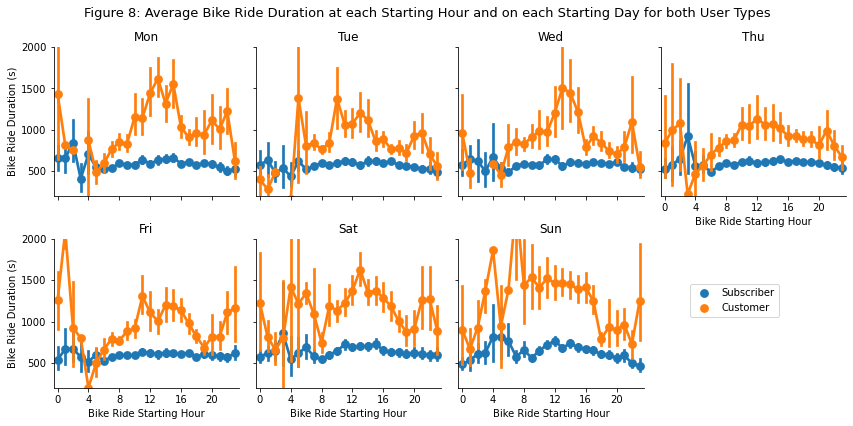

In [16]:
# FacetGrid across 'start_time_dotw' and pointplot of duration_sec(y) vs. start_time_hr(x) with 
# hue='user_type'  parameter and with  col_wrap=4  parameter.
fg = sb.FacetGrid(data=gobike_clean, col='start_time_dotw', col_wrap=4)
plt.suptitle('Figure 8: Average Bike Ride Duration at each Starting Hour and on each Starting Day for both User Types',
            fontsize=13)

fg.map(sb.pointplot, 'start_time_hr', 'duration_sec', 'user_type', palette=[color_0, color_1])
x_ticks3 = [0, 4, 8, 12, 16, 20]
y_ticks4 = [500, 1000, 1500, 2000]

# REFERENCE 1:  Seaborn FacetGrid documentation, https://seaborn.pydata.org/generated/seaborn.FacetGrid.html.

# Dictionary for converting 0 - 6 Day of the Week designations to Mon - Sun.
col_dict = {'0': 'Mon', '1': 'Tue', '2': 'Wed' , '3': 'Thu', '4': 'Fri', '5': 'Sat', '6': 'Sun'}

# Change FacetGrid x- and y-axis labels.
fg.set_axis_labels('Bike Ride Starting Hour', 'Bike Ride Duration (s)')

# EXAMPLE FROM ABOVE REFERENCE 1 to access the underlying FacetGrid matplotlib objects (axes) ...
#
#    g = sns.FacetGrid(tips, col="sex", row="time", margin_titles=True, despine=False)
#    g.map_dataframe(sns.scatterplot, x="total_bill", y="tip")
#    g.figure.subplots_adjust(wspace=0, hspace=0)
#
#    for (row_val, col_val), ax in g.axes_dict.items():
#
#        if row_val == "Lunch" and col_val == "Female":
#            ax.set_facecolor(".95")
#        else:
#            ax.set_facecolor((0, 0, 0, 0)) 
#
#    REM: Python  my_dict.items()  method returns a list of (key, value) tuples.

for col_val, ax in fg.axes_dict.items():
#   print(col_val)                        # Just a check; consecutively on each new line, printed 0  1  2  3  4  5  6 .
    ax.set_title(col_dict[str(col_val)])  # Using my col_dict and col_val (0 through 6) to convert each axes title to Mon - Sun.

# Change FacetGrid xlim, ylim, xticks, and yticks as needed.
fg.set(ylim=(200, 2000), xticks=x_ticks3, yticks=y_ticks4)


# Add and Position the Legend.

# OPTION 1: REFERENCE 2 - https://www.statology.org/seaborn-legend-outside/
plt.legend(bbox_to_anchor=(1.25, 0.70), loc='upper left', borderaxespad=0);

# OPTION 2: REFERENCE 3 - 
#         https://stackoverflow.com/questions/54209895/seaborn-relplot-how-to-control-the-location-of-the-legend-and-add-title.
# fg.add_legend()    # NOTE: This line of code was required with the two "leg..." lines below; otherwise, 
#                            AttributeError: 'NoneType' object has no attribute 'set_bbox_to_anchor'  ERROR.
# leg = fg._legend
# leg.set_bbox_to_anchor([0.85,0.30])    # Apparently, x and y from lower left overall figure origin (0, 0).

# ALSO TRIED THE FOLLOWING:
# sb.move_legend(fg, 'lower right', bbox_to_anchor=(.85, .30));  
    # ERROR:  AttributeError: module 'seaborn' has no attribute 'move_legend'.  NOT SURE WHY sb.move_legend() 
    #         function is being considered as an "attribute" rather than a method, perhaps a seaborn version difference wrt
    #         https://seaborn.pydata.org/generated/seaborn.move_legend.html?highlight=legend#seaborn.move_legend.

# NOTE: Interesting that the mid-day rides by the Subscribers also were of about the same average duration
#       during the week days (back-and-forth from home and work across the day hours, perhaps).

## Duration versus Start-to-End Station Distance for each User Type (Figure 9)
The above distribution of start-to-end station distances showed a small, zero-distance subpopulation and a large, nonzero-distance subpopulation of bike rides (Figure 4). Looking further at the relationship between the outcome variable of interest, bike ride duration (`duration_sec`), and start-to-end station distance (`lin_distance`), it can be seen that the majority of nonzero-distance data points compose a positively-sloped "linear cluster" (Figure 9). These data points are consistent with a purposeful ride from one location to another, such as that by a work commuter. Also present was a second "recreational" grouping of longer-duration bike rides of zero or short (< 4 km) linear distance that are graphically to the left of and above the linear cluster (Figure 9). Along with the violinplot of `user_type` vs. `log10_duration`(Figure 6), this plot shows a modestly greater proportion of Customer rides falling in the so-called longer-duration "recreational" grouping (to the left of and above the "purposeful" linear cluster of rides). Conversely, this indicates that a greater proportion of Subscriber rides fell within the "purposeful" linear cluster. 

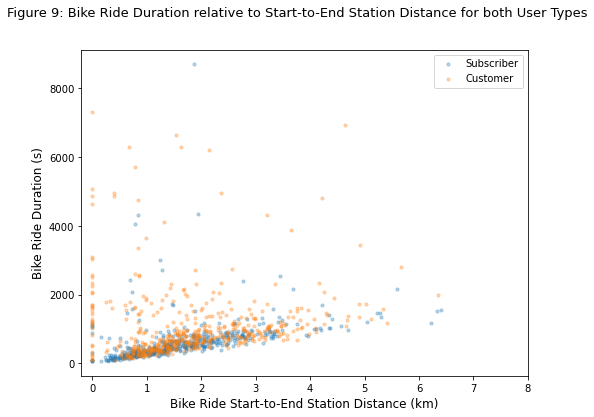

In [17]:
# Scatterplot of a sampling of an EQUIVALENT NUMBER of "Subscriber" and "Customer" data points
# and with the markers of the same shape, fairly high transparency, and smaller size.
user_marker = [['Subscriber', 'o'],
               ['Customer', 'o']]

plt.figure(figsize=[8, 6])
plt.suptitle('Figure 9: Bike Ride Duration relative to Start-to-End Station Distance for both User Types', fontsize=13)

sample_size = 500

for cat, marker in user_marker:
    plot_data = gobike_clean.query('user_type == @cat')
    plot_data = plot_data.sample(sample_size)              # For equivalent plotted Subscriber and Customer sample sizes.
    plt.scatter(data=plot_data, x='lin_distance', y='duration_sec', marker=marker, alpha=0.3, s=10)
    plt.xlim(-0.2, 8)                                      # Increased transparency (alpha= ); decreased marker size (s= ).
    plt.xlabel('Bike Ride Start-to-End Station Distance (km)', fontsize=12)
    plt.ylabel('Bike Ride Duration (s)', fontsize=12)
    
    plt.legend([user_marker[0][0], user_marker[1][0]]);

## Duration versus Start-to-End Station Distance relative to Average Rider Age (Figure 10)
Considering whether "working age" riders, rather than younger or older riders, tend to more often fall within the linear cluster of the `duration` vs. `lin_distance` plot, a 2D Heatmap of `duration` vs. `lin_distance` with sequential coloring of the average rider age within each grid bin was generated. Interestingly, there did appear to be a solid presence of working age riders (early to mid-30s) on average within the linear cluster and more of a variety of younger (more yellow) and older (more blue) riders on average associated with rides "above" the linear cluster. However, the wide ranging number of bike rides in the various 2D Heatmap grid bins suggests a need for caution in the interpretation of the pattern of these color-encoded average ages.

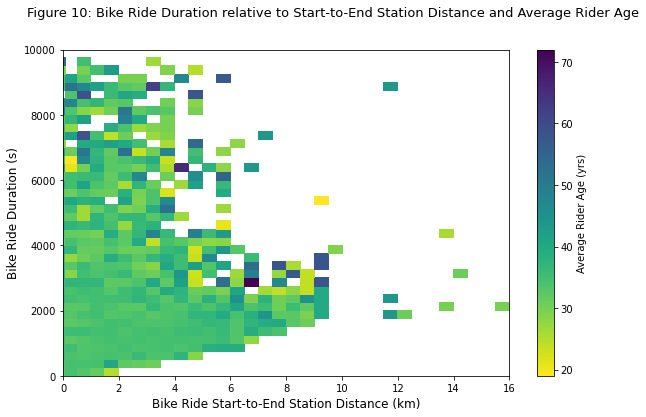

In [18]:
# 2D Heatmap of duration_sec vs. lin_distance with sequential colored average rider_age to see if 
# "working age" riders likely to ride a bike to work (presumably about 25 - 40ish) tend to be more represented
# among the nonzero distance linear cluster.

# Initial pd.cut() with specified x and y bins for duration_sec vs. start_time_hr and mean of the ages w/in each grid bin.
x_bins = [0.0, 0.1, 0.5] + list(np.arange(1.0, 16.5, 0.5))
y_bins = np.arange(0.0, 10005, 250)

# Identify the 'lin_distance'(x) bin and the 'duration_sec'(y) bin that each data point is in:
# REM: For pd.cut() of scalar (single) values, "left" bin values are exclusive (add 'include_lowest=True') 
# and "right" bin values are inclusive; labels=False to default to numeric  AND  .astype(int)
# to make later indexing easier.
lin_dist_bins = pd.cut(gobike_clean.lin_distance, x_bins, include_lowest=True, labels=False).astype(int)
duration_bins = pd.cut(gobike_clean.duration_sec, y_bins, include_lowest=True, labels=False).astype(int)

# Number of points in each grid bin.
n_points = gobike_clean.groupby([lin_dist_bins, duration_bins])
n_points = n_points.size()

# Now, convert the MultiIndex 'n_points' Series to the appropriate 2D array/matrix 
# (correct x and y dimensions wrt 'lin_distance' and 'duration_sec', respectively).

# Convert the MultiIndex 'n_points' Series to its DataFrame form using  .reset_index() .
n_points = n_points.reset_index(name='count') 

# Pivot the 'duration_sec' column values to column headers/indexes and retain the 'lin_distance' column values
# as row indexes.
n_points = n_points.pivot(index='lin_distance', columns='duration_sec')

# Because of later IndexError, fill out missing numbered rows in the 'n_points' 2D array with NaNs. 
# REM: lin_distance Rows needed = 21, 22, 23, 26, 27, 30, 31
# Generate multiple rows of all NaNs consistent with needed number of rows.
row_indexes_to_add = [21, 22, 23, 26, 27, 30, 31]
nan_matrix = np.empty((len(row_indexes_to_add), 39), dtype=np.float64)
nan_matrix.fill(np.nan)

# Generate the appropriately indexed rows of all NaNs that also have the correct 'n_points' MultiIndexed columns
# needed for subsequent appending to 'n_points_full'.
rows_to_add = pd.DataFrame(index=row_indexes_to_add, columns=n_points.columns, data=nan_matrix, dtype='float64')

# Append the rows with all NaNs to 'n_points_full'.
n_points_full = n_points.append(rows_to_add, ignore_index=False)

# SORT BY 'duration_sec' n_point_full.index values to get the grid bin count values in the proper 2D positions
# (as susggested by the "IndexError: index 32 is out of bounds for axis 0 with size 26" error).
n_points_full = n_points_full.sort_index()

# Convert the DataFrame into a 2D array/matrix of the size/count values.
n_points_full = n_points_full.values

# (From my UDACITY Classroom notes) Now we can get the "weight" for each point using all of the above values 
# by taking the gobike_clean['rider_age'] Series  and  dividing each element by the number of points in each grid bin
# by using the "cut" bin vectors [indexes] for indexing into the correct places.  
rider_ages = gobike_clean['rider_age']
gridbin_counts = n_points_full[lin_dist_bins, duration_bins]

# Generate the 'age_weights' argument for the plt.hist2d() 'weights' parameter.
age_weights = rider_ages/gridbin_counts


# Plot 2D Heatmap of duration_sec vs. lin_distance vs. sequential colored (avg) rider_age to see if 
# relatively young(min = 18 y/o) and/or older (potentially non-working) riders tend to take longer duration rides.

# Specific Numeric vs. Numeric w/ Color-encoded Numeric Mean, "DataVisualization2021_06_08.docx", Lesson 5: Multivariate...,
# Section (6), example using plt.hist2d()  and  weights=  parameter.

# 2D Heatmap plot.
plt.figure(figsize=[10, 6])
plt.suptitle('Figure 10: Bike Ride Duration relative to Start-to-End Station Distance and Average Rider Age', fontsize=13)

plt.hist2d(data=gobike_clean, x='lin_distance', y='duration_sec', cmap='viridis_r', cmin=10, 
           bins=[x_bins, y_bins], weights=age_weights)
           # NOTE: 'cmin' set to 10 to avoid relatively meaningless color differences in sparse data areas of the plot.
plt.colorbar(label='Average Rider Age (yrs)')
plt.xlabel('Bike Ride Start-to-End Station Distance (km)', fontsize=12)
plt.ylabel('Bike Ride Duration (s)', fontsize=12);

## Conclusions:
> Figure 8: Longer duration bike rides (on average) are taken by "Customers" compared to "Subscribers" during most non-"early morning" hours, particularly the midday hours, for all days of the week. Longer-duration Customer rides are generally more prevalent on weekend days (Saturday and Sunday), with an apparent modest increase in midday bike ride durations for Subscribers on the weekend days as well.<br><br>
> Figure 9: A greater proportion of longer-duration Customer bike rides fall into the so-called "recreational" data points (to the left of and above the linear cluster of data points).  Conversely, a greater proportion of Subscriber bike rides fall into the "purposeful" linear cluster of data points, which are likely to include work commuter riders.<br><br>
> Figure 10: The average ages of bikers taking rides that fall in the "purposeful" linear cluster are consistent with that of working age individuals who might be expected to bike to work (i.e., predominantly early to mid-30s on average).  Conversely, a wider variety of younger (more yellow) and older (more blue) riders on average appear to be associated with "recreational" rides above the linear cluster.

## Summary:
  Overall, Customers bike relatively more often during the midday hours and on weekend days compared to Subscribers (Figure 7). Moreover, the average duration of Customer bike rides are notably longer during the midday hours of all days of the week compared to that of Subscribers (Figure 8). These longer duration Customer bike rides also appear to often be more "recreational/round trip" in nature (Figure 9) and appear to involve relatively younger or older riders (Figure 10). This is in contrast to the more prevalent Subscribers who bike relatively more often around traditional peak starting and ending work hours (hour 8 and 17) and on week days (Mon. through Fri.) (Figure 7). Subscribers also tend to take rides that fall within the aforementioned "linear cluster" of presumably more "purposeful/work commuter" rides that involve, on average, working age riders that might be expected to bike to work (Figure 9 and 10). The longer durations among these linear-cluster rides are directly proportional to longer start-to-end station distances, with a typical maximum distance of about 8 km (Figure 9). Therefore, while there is substantial overlap among subpopulations, longer, common-duration bike ride times tend to involve "recreational/round trip" Customer riders or longer distance "purposeful/work commuter" Subscriber riders.

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!